In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import lmfit
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
import scipy.optimize as optimize
import corner
G=4.321

In [2]:
print('******************************************************************************************************')
print('README:')
print('******************************************************************************************************')
print('This program is intended to perform mass mass modelling of the disc galaxies following Bayesian Analysis \n')
print('The galaxy is decomposed into following mass components \n Bulge + stellar disc + gas disc + Dark matter halo \n. \n As of now, the following dark matter profiles are  implimented in the code \n \n 1)Cored Pseudo-isothermal dark matter halo \n 2)Cuspy Navvaro- Frenk- white (NFW) dark matter halo \n 3)Burkert dark matter halo \n')
print('For each of the dark matter halo the program calculates the following cases \n 1)Estimates the upper liimits on the dark matter using minimum disc model \n 2)Estimates the dark matter density parameters along with the M/L of th disc as a free parameters \n 3)Estimates the dark matter density parameters for the given M/L ratio derived by the user using the population synthesis models \n 4) Allows user to derive the maximum disc models by first graphically adjusting the M/L to derive the maximum possibe M/L and then further fit the robserved rotation curve to derive the lower limits on the dark matter in the disc galaxy.')
print('The input paramters for the program are the observed rotation curve due to the stars in disc and the bulge, the total observed rotation curve and the rotation curve due to the HI gas, along with the M/L ratios derived from the population synthesis models and the gas correction factor.')

print('How to enter the input parameter? \n')
print('1) Enter the rotation velocities of each of the components alongwith the total rotation velocities as a INPUT.csv file in rotmod format : ')      
print('radius|V_total|V_error|V_bulge|V_disc|V_gas \n')
print('2)Enter the M/L ratio and the density correction factor for the gas in multipliers.csv in the following format:  ')
print('Md|Mg|Mb \n')

print('Also note, if the stellar rotation curve is derived assuming M/L not equal to 1, then the user should input Md=1 in the multipliers.csv file \n' )

print('3)If the stellar, gas and the bulge velocities are not input from the file, then the program can calculate the rotation velocity for the stellar disc assuming a exponential disc, rotation velocities of the gas disc assuming double gaussian density profile, and Hernquist profile for the bulge, the user would then be asked to enter the following : \n')


print('1) Central surface densities Sigma0 and and the disc scalelenght RD of the exponential density profile')
print('Where the exponential density profile is ***Sigma(R)=Sigma0*exp(-R/RD)*** \n')      

print('2)The parameters corresponding the double gaussian density distribution A,B,R01,R02,Rg1,Rg2')
print('Sigma(R)=Sigma_01*exp(-(R-R01)^2)/(2*Rg1^2) + Sigma_02*exp(-(R-R02)^2)/(2*Rg2^2) \n ')

print('3)The parameter corresponding to the density of the bulge parametried as a Hernquist profile, the central Mass (M0) and the scalefactor a ')
print('rho(R)= (M/2pi)*(a/R)*(1/(R+a)**3) \n')


print('4) Input the observed rotation curve as a function of radius at different radius and the corresponding error-bars')


******************************************************************************************************
README:
******************************************************************************************************
This program is intended to perform mass mass modelling of the disc galaxies following Bayesian Analysis 

The galaxy is decomposed into following mass components 
 Bulge + stellar disc + gas disc + Dark matter halo 
. 
 As of now, the following dark matter profiles are  implimented in the code 
 
 1)Cored Pseudo-isothermal dark matter halo 
 2)Cuspy Navvaro- Frenk- white (NFW) dark matter halo 
 3)Burkert dark matter halo 

For each of the dark matter halo the program calculates the following cases 
 1)Estimates the upper liimits on the dark matter using minimum disc model 
 2)Estimates the dark matter density parameters along with the M/L of th disc as a free parameters 
 3)Estimates the dark matter density parameters for the given M/L ratio derived by the user using the po

In [3]:
#Function for calculating the rotation velocity of the stellar disk#
def STARDISK_rotvel(R,Sigma_0,RD):
    R=radius
    Y=R/(2*RD)
    return np.sqrt((4*np.pi*G*(SIGMA_0)*RD)*(Y**2)*( i0(Y)*k0(Y) -i1(Y)*k1(Y)))

In [4]:
#Function to calculate the rotation velocity of the bulge#
def BULGE_rotvel(R,M0,a):
    return np.sqrt( (G*10**-6)*(M0*10**10)*R) / (R+a) 

In [5]:
#Function to calculate the rotation velocity of the  gaussian profile#
def GAS_rotvel(R,S_g,R0,Rg):
    Yg_sq=((R-R0)**2)/(4*Rg**2)
    omega_G_sq=  np.sqrt(np.pi/2) * (np.pi*G*S_g/Rg) * np.exp(-Yg_sq) * ( i0(Yg_sq) - i1(Yg_sq) )
    return R*np.sqrt(omega_G_sq)   

Does user intend to enter the inputs from the file?yes


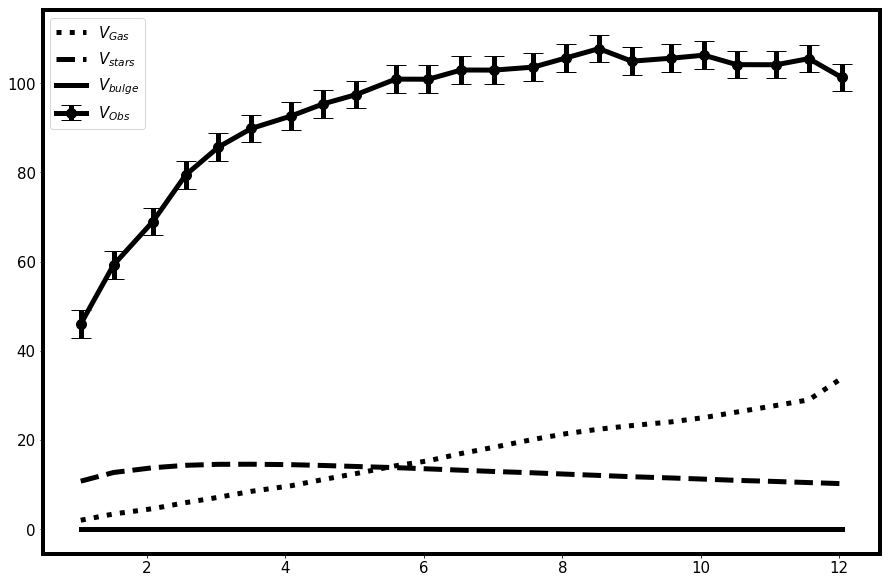

In [6]:
choice1=input("Does user intend to enter the inputs from the file?")
if(choice1=='yes'):
    #Read in the input CSV file
    V_inp=pd.read_csv("INPUT.csv")
    radius=V_inp['radius']
    V_total=V_inp['V_total']
    V_err=V_inp['V_err']
    V_bulge=V_inp['V_bulge']
    V_disc=V_inp['V_disc']
    V_gas=V_inp['V_gas']
    #READ IN GAS CORRECTION FACTOR Mg, Md for stellar disc and Mb for bulge
    Multipliers=pd.read_csv("multipliers.csv")
    Mg=Multipliers['Mg'][0]
    Md=Multipliers['Md'][0]
    Mb=Multipliers['Mb'][0]
    r=radius
    #Plot the input rotation curves:
    plt.rc('axes', linewidth=4)
    plt.rc('axes', labelsize=12)    
    plt.rc('xtick', labelsize=15)    
    plt.rc('ytick', labelsize=15)    
    plt.rc('legend', fontsize=15)    
    figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
    ax.errorbar(r, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
    ax.plot(r,np.sqrt(Mg)*V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
    ax.plot(r,np.sqrt(Md)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
    ax.plot(r,np.sqrt(Mb)*V_bulge,label='$V_{bulge}$',color='black',lw=5,ls='solid')   
    plt.legend()
    plt.savefig('input-rotcurve.pdf',dpi=300)
elif(choice1 == 'no'):
    print('Enter the component-wise densities:')
    print('*******************************************************')    
    print('Enter the number of radial points, corresponding radius values, observed rotation velocities and the error bars ')
    radius = []
    n = int(input('Enter the number of radial points: '))
    for i in range(0, n):
        radius = input('Enter radius values: ')
        radius.append(radius)
    V_total = []
    for i in range(0, n):
        V_total = input('Enter the values of the observed rotation velocities at each radius: ')
        V_total.append(V_total)    
    V_err = []
    for i in range(0, n):
        V_err = input('Enter the error bars of the observed rotation velocities at each radius: ')
        V_err.append(V_err)
    print('Calculate the Rotation velocity of the stellar disk')
    SIGMA_0=input('Enter the central stellar surface density(units=msun/pc^2)')
    RD=input('Enter the Disc Scalelength(units=kpc)')    
    V_disc=STARDISK_rotvel(R,SIGMA_0,RD)
    print('Calculate the rotation velocity of the bulge')
    M0=input('Enter the mass of the bulge in multiples of (10**10)(units=Msun)')
    a=input('Enter scale factor of hernquist profile') 
    V_bulge=BULGE_rotvel(R,M0,a)
    print('Calculate the rotation curve of the gas disk')
    S01=input('Enter the central surface density of the disc1(units=Msun/pc2')
    R01=input('Enter the offset of the disc 1(units=kpc)')
    Rg1=input('Enter the width of the gaussian disc1 (unit=kpc) ')
    S02=input('Enter the central surface density of the disc2(units=Msun/pc2')
    R02=input('Enter the offset of the disc2(units=kpc)')
    Rg2=input('Enter the width of the gaussian disc2 (units=kpc) ')
    V_gas=np.sqrt(  (GAS_rotvel(R,S_g1,R01,Rg1)**2) +(GAS_rotvel(R,S_g2,R02,Rg2)**2))
    print('Enter gas correction factor')
    Mg=input('Enter the correction factor to be multiplied with the gas density to correct for presence of helium and oher metals')
    Md=input('Enter the M/L derived for the stellar disc derived from the population synthesis models')
    Mb=input('Enter the M/L derived from the population synthesis models for the bulge component')
    #Plot the input rotation curves:
    plt.rc('axes', linewidth=4)
    plt.rc('axes', labelsize=12)    
    plt.rc('xtick', labelsize=15)    
    plt.rc('ytick', labelsize=15)    
    plt.rc('legend', fontsize=15)    
    figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
    ax.errorbar(r, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$'),
    ax.plot(r,np.sqrt(Mg)*V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
    ax.plot(r,np.sqrt(Md)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
    ax.plot(r,np.sqrt(Mb)*V_bulge,label='$V_{bulge}$',color='black',lw=5,ls='solid')    
    plt.legend()
    plt.savefig('input-rotcurve.pdf',dpi=300)    


# Define the rotation curves corresponding to the dark  matter density profile

In [7]:
def pseudo_Isothermal(r,RHO_0,R_C):
    PIS_h=np.sqrt((4*np.pi*G*(RHO_0)*R_C**2)*(1- (R_C/r)*np.arctan(r/R_C)))
    return np.sqrt(PIS_h* PIS_h + Mg*V_gas*abs(V_gas)  + Md *V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) )

In [8]:
def pseudo_Isothermal_FREE_ML(r,RHO_0,R_C,ML):
    PIS_h= np.sqrt((4*np.pi*G*(RHO_0)*R_C**2)*(1- (R_C/r)*np.arctan(r/R_C)))
    return np.sqrt( PIS_h*PIS_h + Mg*V_gas*abs(V_gas)  + ML *V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) )

In [9]:
def pseudo_Isothermal_Minimum_Disk(r,RHO_0,R_C):
    PIS_h= np.sqrt((4*np.pi*G*(RHO_0)*R_C**2)*(1- (R_C/r)*np.arctan(r/R_C)))
    return PIS_h

In [10]:
#def pseudo_Isothermal_maxDisc(r,RHO_0,R_C):
#    PIS_h=np.sqrt((4*np.pi*G*(RHO_0)*R_C**2)*(1- (R_C/r)*np.arctan(r/R_C)))
#    return np.sqrt(PIS_h* PIS_h + Mg*V_gas*abs(V_gas)  + maxML*V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) )


In [11]:
def NFW(r,C,R200):
    NFW_h= (R200/0.73)*np.sqrt( (R200/r)*((np.log(1+r*(C/R200))-(r*(C/R200)/(1+r*(C/R200))))/(np.log(1+C) - (C/(1+C)))))                    
    return np.sqrt(NFW_h * NFW_h + Mg*V_gas*abs(V_gas)  + Md *V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) ) 

In [12]:
def NFW_FREE_ML(r,C,R200,ML):
    NFW_h= (R200/0.73)*np.sqrt( (R200/r)*((np.log(1+r*(C/R200))-(r*(C/R200)/(1+r*(C/R200))))/(np.log(1+C) - (C/(1+C)))))                    
    return np.sqrt(NFW_h* NFW_h + Mg*V_gas*abs(V_gas)  + ML *V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) ) 

In [13]:
def NFW_Minimum_Disk(r,C,R200):
    NFW_h= (R200/0.73)*np.sqrt( (R200/r)*((np.log(1+r*(C/R200))-(r*(C/R200)/(1+r*(C/R200))))/(np.log(1+C) - (C/(1+C)))))                    
    return NFW_h

In [14]:
#def NFW_maxDisc(r,C,R200,maxML):
#    NFW_h= (R200/0.73)*np.sqrt( (R200/r)*((np.log(1+r*(C/R200))-(r*(C/R200)/(1+r*(C/R200))))/(np.log(1+C) - (C/(1+C)))))                    
#    return np.sqrt(NFW_h * NFW_h + Mg[0]*V_gas*abs(V_gas)  + maxML *V_disc*abs(V_disc) + Mb[0]*V_bulge*abs(V_bulge) ) 

In [15]:
def BURKERT(r,RHO_0,R_C):
    BURKERT_h=np.sqrt((6.4*G*RHO_0*((R_C**3)/r))*(  np.log(1+(r/R_C)) - np.arctan(r/R_C)  + 0.5*np.log( 1+ (r/R_C)**2) ))           
    return np.sqrt(BURKERT_h* BURKERT_h + Mg*V_gas*abs(V_gas)  + Md *V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) ) 

In [16]:
def BURKERT_FREE_ML(r,RHO_0,R_C,ML):
    BURKERT_h=np.sqrt((6.4*G*RHO_0*((R_C**3)/r))*(  np.log(1+(r/R_C)) - np.arctan(r/R_C)  + 0.5*np.log( 1+ (r/R_C)**2) ))           
    return np.sqrt(BURKERT_h* BURKERT_h + Mg*V_gas*abs(V_gas)  + ML *V_disc*abs(V_disc) + Mb*V_bulge*abs(V_bulge) ) 

In [17]:
def BURKERT_Minimum_Disk(r,RHO_0,R_C):
    BURKERT_h=np.sqrt((6.4*G*RHO_0*((R_C**3)/r))*(  np.log(1+(r/R_C)) - np.arctan(r/R_C)  + 0.5*np.log( 1+ (r/R_C)**2) ))           
    return BURKERT_h

In [18]:
#def BURKERT_maxDisc(r,RHO_0,R_C,maxDisc):
#    BURKERT_h=np.sqrt((6.4*G*RHO_0*((R_C**3)/r))*(  np.log(1+(r/R_C)) - np.arctan(r/R_C)  + 0.5*np.log( 1+ (r/R_C)**2) ))           
#    return np.sqrt(BURKERT_h* BURKERT_h + Mg[0]*V_gas*abs(V_gas)  + maxDisc *V_disc*abs(V_disc) + Mb[0]*V_bulge*abs(V_bulge) ) 

# Initial parameter optimization using differential evolution algorithm, write out the basic statistics to the file and plot the data, fit and the residuals;

In [19]:
def INITIAL_GUESS(f,R,V):
    func=f
    xData=R
    yData=V
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") 
        val = func(xData, *parameterTuple)
        return numpy.sum((yData - val) ** 2.0)
    def generate_Initial_Parameters():
        maxX = max(xData)
        minX = min(xData)
        maxY = max(yData)
        minY = min(yData)
        parameterBounds = []
        parameterBounds.append([0.1, 1000])
        parameterBounds.append([0.1, 1000])
        result = differential_evolution(sumOfSquaredError, parameterBounds)
        return result.x
    geneticParameters = generate_Initial_Parameters()
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
    print('Parameters', fittedParameters)
    modelPredictions = func(xData, *fittedParameters) 
    absError = modelPredictions - yData
    A, B = fittedParameters
    dA, dB= \
          [np.sqrt(pcov[j,j]) for j in range(fittedParameters.size)]
    f_fit = radius
    s_fit = func(radius,A,B)
    resids = yData - func(radius,A,B)
    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    f_fit = r
    s_fit = func(r,A,B)
    resids = yData - func(r,A,B)
    redchisqr = ((resids/V_err)**2).sum()/float(r.size-2)
    if(func==pseudo_Isothermal):
        f = open("Inital_estimates_PIS.txt", "w+")
        print("Inital estimates for Pseudo-Isothermal-Halo: M/L Fixed",file=f)
        print("----------------------------------------------",file=f)
        print("RHO_0=",A,"RC=",B,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==pseudo_Isothermal_Minimum_Disk):
        f = open("Inital_estimates_PIS_MinimumDISK.txt", "w+")
        print("Inital estimates for Pseudo-Isothermal-Halo: Minimum Disk",file=f)
        print("----------------------------------------------",file=f)
        print("RHO_0=",A,"RC=",B,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==NFW):
        f = open("Inital_estimates_NFW.txt", "w+")
        print("Inital estimates for NFW-Halo: M/L Fixed",file=f)
        print("----------------------------------------------",file=f)
        print("C=",A,"R200=",B,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==NFW_Minimum_Disk):
        f = open("Inital_estimates_NFW_Minimum Disk.txt", "w+")
        print("Inital estimates for NFW-Halo: Minimum Disk",file=f)
        print("----------------------------------------------",file=f)
        print("C=",A,"R200=",B,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==BURKERT):
        f = open("Inital_estimates_BURKERT.txt", "w+")
        print("Inital estimates for BURKERT-Halo: M/L fixed",file=f)
        print("----------------------------------------------",file=f)
        print("RHO_0=",A,"R0=",B,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==BURKERT_Minimum_Disk):
        f = open("Inital_estimates_BURKERT.txt", "w+")
        print("Inital estimates for BURKERT-Halo: Minimum Disk",file=f)
        print("----------------------------------------------",file=f)
        print("RHO_0=",A,"R0=",B,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    return geneticParameters

In [20]:
def INITIAL_GUESS_ML_free(f,R,V):
    func=f
    xData=R
    yData=V
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") 
        val = func(xData, *parameterTuple)
        return numpy.sum((yData - val) ** 2.0)
    def generate_Initial_Parameters():
        maxX = max(xData)
        minX = min(xData)
        maxY = max(yData)
        minY = min(yData)
        parameterBounds = []
        parameterBounds.append([0.1, 100]) # seach bounds for RHO_0
        parameterBounds.append([0.1, 200]) # seach bounds for R_C
        parameterBounds.append([0.1, 200]) # seach bounds for M/L
        result = differential_evolution(sumOfSquaredError, parameterBounds)
        return result.x
    geneticParameters = generate_Initial_Parameters()
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
    print('Parameters', fittedParameters)
    modelPredictions = func(xData, *fittedParameters) 
    absError = modelPredictions - yData
    A, B, ML = fittedParameters
    dA, dB, dML= \
          [np.sqrt(pcov[j,j]) for j in range(fittedParameters.size)]
    f_fit = radius
    s_fit = func(radius,A,B,ML)
    resids = yData - func(radius,A,B,ML)
    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    f_fit = r
    s_fit = func(r,A,B,ML)
    resids = yData - func(r,A,B,ML)
    redchisqr = ((resids/V_err)**2).sum()/float(r.size-2)
    if(func==pseudo_Isothermal):
        f = open("Inital_estimates_PIS_FreeML.txt","w+")
        print("Inital estimates for Pseudo-Isothermal-Halo: M/L Free",file=f)
        print("----------------------------------------------",file=f)
        print("RHO_0=",A,"RC=",B,"M/L=",ML,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==NFW):
        f = open("Inital_estimates_NFW_FreeML.txt", "w+")
        print("Inital estimates for NFW-Halo: M/L Free",file=f)
        print("----------------------------------------------",file=f)
        print("C=",A,"R200=",B,"M/L=",ML,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    if(func==BURKERT):
        f = open("Inital_estimates_BURKERT_FreeML.txt", "w+")
        print("Inital estimates for BURKERT-Halo: Minimum Free",file=f)
        print("----------------------------------------------",file=f)
        print("RHO_0=",A,"R0=",B,"M/L=",ML,file=f)
        print("Mean Squared Error=",MSE,file=f)
        print("Root Mean Squared Error=",RMSE,file=f)
        print("Reduced Chi-Square=",redchisqr,file=f)
        f.close()
    return geneticParameters

# Run MCMC SAMPLER using guess values from differential evolution

In [21]:
def MCMC_RUN(f,fit):
    func=f
    if(func==pseudo_Isothermal):
        p1_name='RHO_0'
        p2_name='R_C'
    if(func==NFW):
        p1_name='C'
        p2_name='R200'
    if(func==BURKERT):
        p1_name='RHO_0'
        p2_name='R_C'
    if(func==pseudo_Isothermal_Minimum_Disk):
        p1_name='RHO_0'
        p2_name='R_C'
    if(func==NFW_Minimum_Disk):
        p1_name='C'
        p2_name='R200'
    if(func==BURKERT_Minimum_Disk):
        p1_name='RHO_0'
        p2_name='R_C'
    model = lmfit.Model(func)
    model.set_param_hint(p1_name,value=fit[0], min=0.0,max=80,vary=True)
    model.set_param_hint(p2_name,value=fit[1], min=0.0,max=10,vary=True)
    p = model.make_params()
    result = model.fit(data=V_total, params=p, r=radius,method='NELDER', nan_policy='omit')
    emcee_kws = dict(steps=50, burn=5, thin=1, is_weighted=False)
    emcee_params = result.params.copy()
    emcee_params.add('__lnsigma',value=np.log(0.1*max(V_total)), min=-10, max=10)
    result_emcee = model.fit(data=V_total, r=radius, params=emcee_params, method='emcee',nan_policy='omit', 
                         fit_kws=emcee_kws)
    if(func==pseudo_Isothermal):
        with open('pseudo_Isothrmal_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                            ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                             "$ \mathrm{R_{c}(kpc)}$","ln(f)"]);   
        fig.savefig('PIS_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        V_th=pseudo_Isothermal(radius,RHO_0,R_C)
        V_DM=pseudo_Isothermal_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(Md)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('PIS_MM.pdf',dpi=300)
    if(func==pseudo_Isothermal_Minimum_Disk):
        with open('pseudo_Isothermal_MinimumDisc_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                    ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                    "$ \mathrm{R_{c}(kpc)}$","ln(f)"]);   
        fig.savefig('PIS_MIN_DISC_COV.pdf',dpi=300) 
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        V_th=pseudo_Isothermal_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('PIS_MinimumDisc_MM.pdf',dpi=300)
    if(func==NFW):
        with open('NFW_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},
            labels = ["$\mathrm{C}$","$ \mathrm{R_{200}(kpc)}$","ln(f)"]);
        fig.savefig('NFW_COV.pdf',dpi=300) 
        C=result_emcee.best_values['C']
        R200=result_emcee.best_values['R200']
        V_DM=NFW_Minimum_Disk(radius,C,R200)
        V_th=NFW(radius,C,R200)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(Md)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('NFW_MM.pdf',dpi=300)
    if(func==NFW_Minimum_Disk):
        with open('NFW_MCMC_MinimumDisc_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},
        labels = ["$\mathrm{C}$","$ \mathrm{R_{200}(kpc)}$","ln(f)"]);
        fig.savefig('NFW_MIN_DISC_COV.pdf',dpi=300)
        C=result_emcee.best_values['C']
        R200=result_emcee.best_values['R200']
        V_th=NFW_Minimum_Disk(radius,C,R200)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('NFW_MinimumDiscMM.pdf',dpi=300)
    if(func==BURKERT):
        with open('Burkert_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                    ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                    "$ \mathrm{R_{c}(kpc)}$","ln(f)"]);  
        fig.savefig('BURKERT_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        V_th=BURKERT(radius,RHO_0,R_C)
        V_DM=BURKERT_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(Md)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('BURKERT_MM.pdf',dpi=300)
    if(func==BURKERT_Minimum_Disk):
        with open('BURKERT_MCMC_MinimumDisc_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())        
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                    ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                    "$ \mathrm{R_{c}(kpc)}$","ln(f)"]);
        fig.savefig('BURKERT_MIN_DISC_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        V_th=BURKERT_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('BURKERT_MinimumDisc_MM.pdf',dpi=300)
    return lmfit.report_fit(result_emcee)

In [22]:
def MCMC_RUN_FREE_ML(f,fit):
    func=f
    if(func==pseudo_Isothermal_FREE_ML):
        p1_n='RHO_0'
        p2_n='R_C'
        p3_n='ML'
    if(func==NFW_FREE_ML):
        p1_n='C'
        p2_n='R200'
        p3_n='ML'
    if(func==BURKERT_FREE_ML):
        p1_n='RHO_0'
        p2_n='R_C'
        p3_n='ML'
        
    model = lmfit.Model(func)
    model.set_param_hint(p1_n,value=fit[0], min=0.0,max=1000,vary=True)
    model.set_param_hint(p2_n,value=fit[1], min=0.0,max=100,vary=True)
    model.set_param_hint(p3_n,value=fit[2], min=0.0,max=100,vary=True)
    p = model.make_params()
    result = model.fit(data=V_total, params=p, r=radius,method='NELDER', nan_policy='omit')
    emcee_kws = dict(steps=50, burn=5, thin=1, is_weighted=False)
    emcee_params = result.params.copy()
    emcee_params.add('__lnsigma',value=np.log(0.1*max(V_total)), min=-10, max=10)
    result_emcee = model.fit(data=V_total, r=radius, params=emcee_params, method='emcee',nan_policy='omit', 
                         fit_kws=emcee_kws)
    if(func==pseudo_Isothermal_FREE_ML):
        with open('pseudo_Isothrmal_FREE_ML_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                            ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                             "$ \mathrm{R_{c}(kpc)}$"
                             ,"M/L","ln(f)"]);   
        fig.savefig('PIS_FreeML_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        ML=result_emcee.best_values['ML']
        V_th=pseudo_Isothermal_FREE_ML(radius,RHO_0,R_C,ML)
        V_DM=pseudo_Isothermal_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(ML)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('PIS_Free_ML.pdf',dpi=300)
    if(func==NFW_FREE_ML):
        with open('NFW_MCMC_Free_ML_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},
                    labels = ["$\mathrm{c}$","$ \mathrm{R_{200}(kpc)}$","M/L","ln(f)"]);   
        fig.savefig('NFW_FREE_ML_COV.pdf',dpi=300) 
        C=result_emcee.best_values['C']
        R200=result_emcee.best_values['R200']
        ML=result_emcee.best_values['ML']
        V_DM=NFW_Minimum_Disk(radius,C,R200)
        V_th=NFW_FREE_ML(radius,C,R200,ML)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(ML)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('NFW_FreeML_MM.pdf',dpi=300)
    if(func==BURKERT_FREE_ML):
        with open('BURKERT_FREE_ML_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                            ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                             "$ \mathrm{R_{c}(kpc)}$"
                             ,"M/L","ln(f)"]);   
        fig.savefig('BURKERT_FreeML_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        ML=result_emcee.best_values['ML']
        V_th=BURKERT_FREE_ML(radius,RHO_0,R_C,ML)
        V_DM=BURKERT_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(ML)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('BURKERT_Free_ML.pdf',dpi=300)

In [23]:
print('Fitting Pseudo-Isothermal Halo with user-defined M/L ratio ')
fit1=INITIAL_GUESS(pseudo_Isothermal,radius,V_total)
MCMC_RUN(pseudo_Isothermal,fit1)
print('Fit Pseudo-Isothermal Halo to the observed rotation curve case to find upper limit of the dark matter distribution (Minimum Disc case)  ')
fit2=INITIAL_GUESS(pseudo_Isothermal_Minimum_Disk,radius,V_total)
MCMC_RUN(pseudo_Isothermal,fit2)
print('Fit Pseudo-Isothermal dark matter profile keeping  the M/L ratio as a free parameter')
fit7=INITIAL_GUESS_ML_free(pseudo_Isothermal_FREE_ML,radius,V_total)
MCMC_RUN_FREE_ML(pseudo_Isothermal_FREE_ML,fit7)
print('Fitting NFW Halo with user-defined M/L ratio ')
fit3=INITIAL_GUESS(NFW,radius,V_total)
MCMC_RUN(NFW,fit3)
print('Fit NFW Halo to the observed rotation curve case to find upper limit of the dark matter distribution (Minimum Disc case)  ')
fit4=INITIAL_GUESS(NFW_Minimum_Disk,radius,V_total)
MCMC_RUN(NFW_Minimum_Disk,fit4)
print('Fit NFW dark matter profile keeping  the M/L ratio as a free parameter')
fit8=INITIAL_GUESS_ML_free(NFW_FREE_ML,radius,V_total)
MCMC_RUN_FREE_ML(NFW_FREE_ML,fit8)
print('Fitting Burkert Halo with user-defined M/L ratio ')
fit5=INITIAL_GUESS(BURKERT,radius,V_total)
MCMC_RUN(BURKERT,fit5)
print('Fit Burkert Halo to the observed rotation curve case to find upper limit of the dark matter distribution (Minimum Disc case)  ')
fit6=INITIAL_GUESS(BURKERT_Minimum_Disk,radius,V_total)
MCMC_RUN(BURKERT_Minimum_Disk,fit6)
print('Fit Burkert dark matter profile keeping  the M/L ratio as a free parameter')
fit9=INITIAL_GUESS_ML_free(BURKERT_FREE_ML,radius,V_total)
MCMC_RUN_FREE_ML(BURKERT_FREE_ML,fit9)

Fitting Pseudo-Isothermal Halo with user-defined M/L ratio 
Parameters [162.51234584   1.20612748]


 46%|████▌     | 23/50 [00:05<00:07,  3.74it/s]

emcee: Exception while calling your likelihood function:
  params: [79.98050244  1.83511625  2.37592775]
  args: (<bound method Model._residual of <lmfit.Model: Model(pseudo_Isothermal)>>, Parameters([('RHO_0', <Parameter 'RHO_0', 79.98050244486176, bounds=[0.0:80]>), ('R_C', <Parameter 'R_C', 1.8351162489906212, bounds=[0.0:10]>), ('__lnsigma', <Parameter '__lnsigma', 2.375927753995674, bounds=[-10:10]>)]), ['RHO_0', 'R_C', '__lnsigma'], array([[  0.,  80.],
       [  0.,  10.],
       [-10.,  10.]]))
  kwargs: {'is_weighted': False, 'float_behavior': 'posterior', 'userargs': (0      45.99600
1      59.22951
2      68.96949
3      79.41151
4      85.66799
5      89.83099
6      92.59450
7      95.36250
8      97.43300
9     100.89400
10    100.87100
11    102.94150
12    102.91850
13    103.58850
14    105.65900
15    107.72950
16    104.91550
17    105.58600
18    106.26100
19    104.14500
20    104.11750
21    105.49000
22    101.28150
Name: V_total, dtype: float64, None), 'userkws'

Traceback (most recent call last):
  File "/home/aditya/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/aditya/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py", line 2206, in _lnpost
    out = userfcn(params, *userargs, **userkwargs)
  File "/home/aditya/anaconda3/lib/python3.7/site-packages/lmfit/model.py", line 760, in _residual
    model = self.eval(params, **kwargs)
  File "/home/aditya/anaconda3/lib/python3.7/site-packages/lmfit/model.py", line 848, in eval
    return self.func(**self.make_funcargs(params, kwargs))
  File "<ipython-input-7-b2dddec2c54e>", line 2, in pseudo_Isothermal
    PIS_h=np.sqrt((4*np.pi*G*(RHO_0)*R_C**2)*(1- (R_C/r)*np.arctan(r/R_C)))
  File "/home/aditya/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py", line 1585, in wrapper
    index=left.index, name=res_name, dtype=None)
  File "/home/aditya/anaconda3/lib/python3.7/site-packages/pandas/core/ops

KeyboardInterrupt: 

In [ ]:
# Now fit the maximum disc case by launching window to maximize the  

In [24]:
print('********************************************************************')
print('Find the lower limit of the dark matter content in the galaxy.')
print('Adjust the the slider to vary the value of the M/L ratio to maximize the contribution of the stellar disc to the observed rotation curve')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def plot_func(M_L):
    plt.plot(r,np.sqrt(M_L)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
    plt.errorbar(r, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
    plt.legend()
interact(plot_func, M_L = widgets.FloatSlider(value=1.0,min=0.01,max=50.0,step=0.005))

********************************************************************
Find the lower limit of the dark matter content in the galaxy.
Adjust the the slider to vary the value of the M/L ratio to maximize the contribution of the stellar disc to the observed rotation curve


interactive(children=(FloatSlider(value=1.0, description='M_L', max=50.0, min=0.01, step=0.005), Output()), _d…

<function __main__.plot_func(M_L)>

In [ ]:
def pseudo_Isothermal_maxDisc(r,RHO_0,R_C):
    PIS_h=np.sqrt((4*np.pi*G*(RHO_0)*R_C**2)*(1- (R_C/r)*np.arctan(r/R_C)))
    return np.sqrt(PIS_h* PIS_h + (0)*V_gas*abs(V_gas)  + maxML*V_disc*abs(V_disc) + (0)*V_bulge*abs(V_bulge) )

def NFW_maxDisc(r,C,R200):
    NFW_h= (R200/0.73)*np.sqrt( (R200/r)*((np.log(1+r*(C/R200))-(r*(C/R200)/(1+r*(C/R200))))/(np.log(1+C) - (C/(1+C)))))                    
    return np.sqrt(NFW_h * NFW_h + (0)*V_gas*abs(V_gas)  + maxML *V_disc*abs(V_disc) + (0)*V_bulge*abs(V_bulge) ) 

def BURKERT_maxDisc(r,RHO_0,R_C):
    BURKERT_h=np.sqrt((6.4*G*RHO_0*((R_C**3)/r))*(  np.log(1+(r/R_C)) - np.arctan(r/R_C)  + 0.5*np.log( 1+ (r/R_C)**2) ))           
    return np.sqrt(BURKERT_h* BURKERT_h + (0)*V_gas*abs(V_gas)  + maxML *V_disc*abs(V_disc) + (0)*V_bulge*abs(V_bulge) ) 


In [34]:
def MCMC_RUN_maxDisc(f,fit):
    func=f
    if(func==pseudo_Isothermal_maxDisc):
        p1_name='RHO_0'
        p2_name='R_C'
    if(func==NFW_maxDisc):
        p1_name='C'
        p2_name='R200'
    if(func==BURKERT_maxDisc):
        p1_name='RHO_0'
        p2_name='R_C'
    model = lmfit.Model(func)
    model.set_param_hint(p1_name,value=fit[0], min=0.0,max=80,vary=True)
    model.set_param_hint(p2_name,value=fit[1], min=0.0,max=10,vary=True)
    p = model.make_params()
    result = model.fit(data=V_total, params=p, r=radius,method='NELDER', nan_policy='omit')
    emcee_kws = dict(steps=50, burn=5, thin=1, is_weighted=False)
    emcee_params = result.params.copy()
    emcee_params.add('__lnsigma',value=np.log(0.1*max(V_total)), min=-10, max=10)
    result_emcee = model.fit(data=V_total, r=radius, params=emcee_params, method='emcee',nan_policy='omit', 
                         fit_kws=emcee_kws)
    
    #****************************************************************************
    #****************************************************************************
    
    if(func==pseudo_Isothermal_maxDisc):
        with open('pseudo_Isothrmal_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                            ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                             "$ \mathrm{R_{c}(kpc)}$","ln(f)"]);   
        fig.savefig('PIS_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        V_th=pseudo_Isothermal_maxDisc(radius,RHO_0,R_C)
        V_DM=pseudo_Isothermal_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(maxML)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('PIS_MM.pdf',dpi=300)
    #***********************************************************************************
    #***********************************************************************************
    if(func==NFW_maxDisc):
        with open('NFW_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},
            labels = ["$\mathrm{C}$","$ \mathrm{R_{200}(kpc)}$","ln(f)"]);
        fig.savefig('NFW_COV.pdf',dpi=300) 
        C=result_emcee.best_values['C']
        R200=result_emcee.best_values['R200']
        V_DM=NFW_Minimum_Disk(radius,C,R200)
        V_th=NFW_maxDisc(radius,C,R200)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(maxML)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('NFW_MM.pdf',dpi=300)
    #*************************************************************************************
    #*************************************************************************************
    if(func==BURKERT_maxDisc):
        with open('Burkert_MCMC_result.txt', 'w+') as fh:
            fh.write(result_emcee.fit_report())
        fig = corner.corner(result_emcee.flatchain, quantiles=[0.16, 0.5, 0.84],show_titles=True,
                    title_kwargs={"fontsize": 15},labels = 
                    ["$\mathrm{\\rho_{c}\\times 10^{-3}(M_{\\odot}/pc^{3})}$",
                    "$ \mathrm{R_{c}(kpc)}$","ln(f)"]);  
        fig.savefig('BURKERT_COV.pdf',dpi=300)
        R_C=result_emcee.best_values['R_C']
        RHO_0=result_emcee.best_values['RHO_0']
        V_th=BURKERT_maxDisc(radius,RHO_0,R_C)
        V_DM=BURKERT_Minimum_Disk(radius,RHO_0,R_C)
        figure, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
        ax.errorbar(radius, V_total, yerr=V_err, ms=10, color='black',lw=5,alpha=1, capsize=10,marker='o', barsabove=True,label='$V_{Obs}$')
        ax.plot(radius,V_gas,label='$V_{Gas}$',color='black',lw=5,ls='dotted')
        ax.plot(radius,np.sqrt(Md)*V_disc,label='$V_{stars}$',color='black',lw=5,ls='dashed')
        ax.plot(radius,V_DM,label='$V_{DM}$',lw=5,color='black',alpha=0.5,marker='s',ms=20)
        ax.plot(radius,V_th,label='$V_{Total}$',color='black',lw=5,ls='solid',alpha=0.5,marker='^',ms=20)
        plt.legend()
        ax.set_xlabel('R(kpc)')
        ax.set_ylabel('V(km/s)')
        plt.savefig('BURKERT_MM.pdf',dpi=300)
        
        
        

Enter the maximum value of the M/L maximizing the disc contribution.14
Fitting Pseudo-Isothermal Halo maximum value of M/L ratio maximizing the disc contibution to the total rotation curve
Parameters [7.94007768 6.86535396]


100%|██████████| 50/50 [00:20<00:00,  3.30it/s]


Fitting NFW Halo maximum value of M/L ratio maximizing the disc contibution to the total rotation curve
Parameters [1.44903202e-01 2.83465310e+02]


100%|██████████| 50/50 [00:15<00:00,  3.06it/s]


Fitting Burkert Halo with maximum value of M/L ratio maximizing the disc contibution to the total rotation curve
Parameters [ 9.22175934 10.46257033]


100%|██████████| 50/50 [00:18<00:00,  2.37it/s]


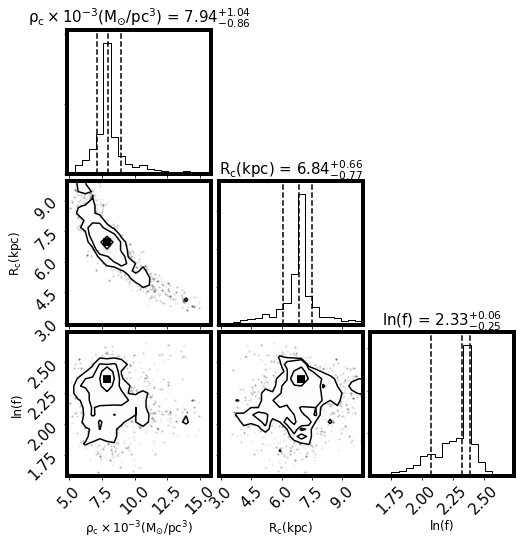

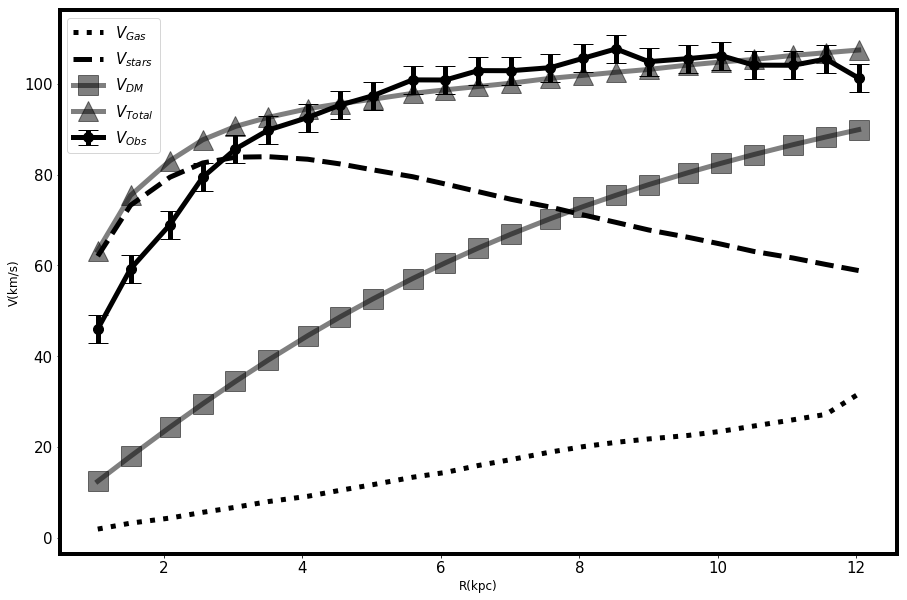

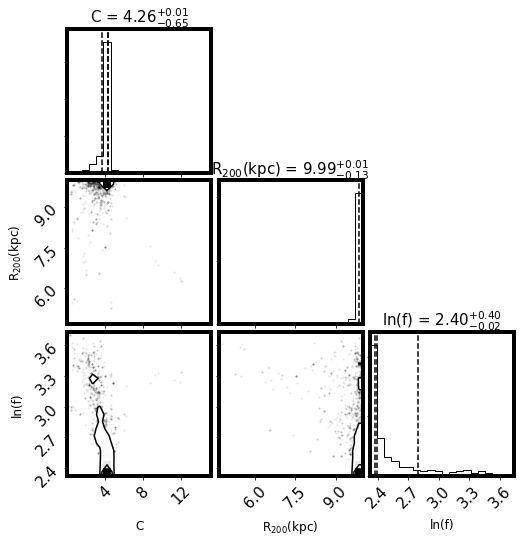

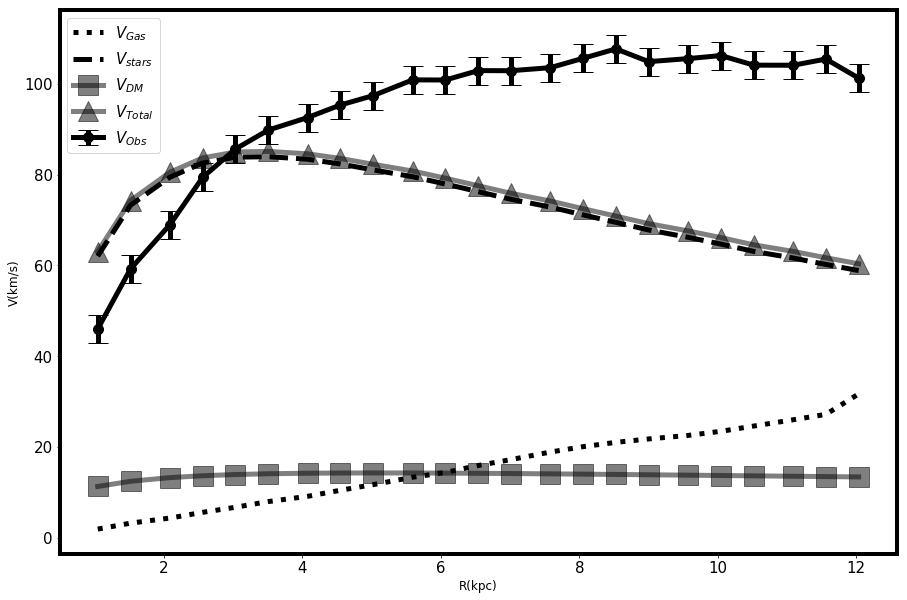

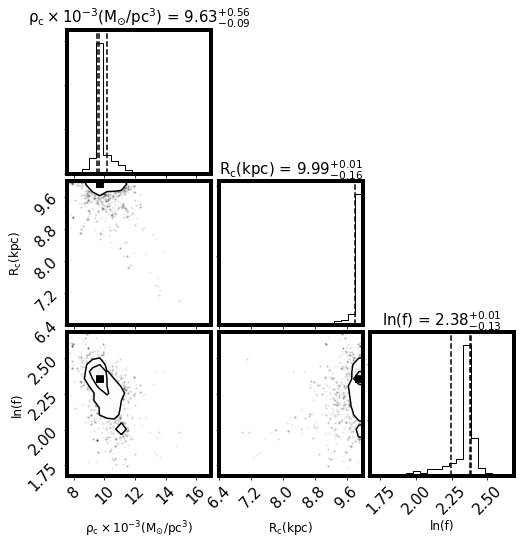

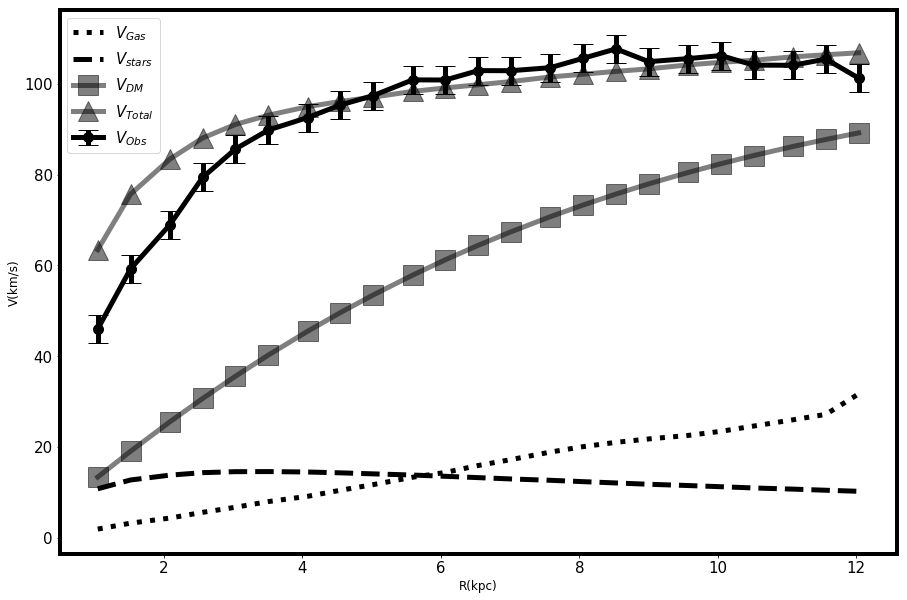

In [36]:
maxML=int(input('Enter the maximum value of the M/L maximizing the disc contribution.'))
print('Fitting Pseudo-Isothermal Halo maximum value of M/L ratio maximizing the disc contibution to the total rotation curve')
fit1=INITIAL_GUESS(pseudo_Isothermal_maxDisc,radius,V_total)
MCMC_RUN_maxDisc(pseudo_Isothermal_maxDisc,fit1)

print('Fitting NFW Halo maximum value of M/L ratio maximizing the disc contibution to the total rotation curve')
fit2=INITIAL_GUESS(NFW_maxDisc,radius,V_total)
MCMC_RUN_maxDisc(NFW_maxDisc,fit2)


print('Fitting Burkert Halo with maximum value of M/L ratio maximizing the disc contibution to the total rotation curve')
fit3=INITIAL_GUESS(BURKERT_maxDisc,radius,V_total)
MCMC_RUN_maxDisc(BURKERT_maxDisc,fit3)


In [ ]:
#radius = []
#n = int(input('Enter the number of radial points: '))
#for i in range(0, n):
#    r = input('Enter radius values: ')
#    radius.append(r)